<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/notebooks/python/Lab_4_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# Data management tools
import pandas as pd
import polars as pl
import polars.selectors as cs

# Data transformation
from scipy.stats import zscore

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Data Preprocessing

In this lab, we will set up a **data pipeline** in order to leave the data ready for analysis. Data preprocessing tends to be, by far, the most time-consuming step of the data science process. Errors in this step propagate to the model, so it is really important we do this correctly.

The goal of this step is to leave the date ready to apply models to it.

Every problem has its own set of data preprocessing functions to apply it to, but we will focus on the ones most common in classification models. In general we want to:

1. Eliminate redundant variables.
2. Treat null values.
3. Treat outliers.
4. Remove correlated features.

For this goal we will use the excellent [```pandas```](https://pandas.pydata.org/) and [Polars](https://docs.pola.rs/api/python/dev/reference/index.html) packages, which allow for data handling in general. We will try to use Polars as much as possible.

## Reading the data

Let's download the Bankloan data. I have slightly modified it removing the PD and LGD information (as we will now estimate our own). As a reminder, it has the following variables:

- Customer: ID, or unique label, of the borrower (NOT predictive).
- Age: Age of the borrower in years.
- Education: Maximum education level the borrower reached.
1: Complete primary. 2: Completed Secondary. 3: Incomplete Higher Ed. 4: Complete Higher Ed. 5: With postgraduate studies (complete MSc or PhD).
- Employ: Years at current job.
- Address: Years at current address.
- Income: Income in ‘000s USD.
- Leverage: Debt/Income Ratio.
- CredDebt: Credit card standing debt.
- OthDebt: Other debt in ‘000s USD.
- MonthlyLoad: Monthly percentage from salary used to repay debts.
- Default: 1 If default has occurred, 0 if not (Target variable).

We will download it now directly from a link, using the more ubiquitous [```wget```](http://www.gnu.org/software/wget/) command. The command is

```
wget [-options] path
```

We need to add the options ```--no-check-certificate``` and ```--output-document=FILENAME``` so it downloads ok.

In [2]:
!wget --no-check-certificate --output-document=Bankloan.csv 'https://docs.google.com/spreadsheets/d/1nUJ1fA5f1VeMvulknpsvxpy0GW3CekNnhgeLRK0WlDI/export?gid=1016776666&format=csv'

--2025-10-16 18:08:58--  https://docs.google.com/spreadsheets/d/1nUJ1fA5f1VeMvulknpsvxpy0GW3CekNnhgeLRK0WlDI/export?gid=1016776666&format=csv
Resolving docs.google.com (docs.google.com)... 108.177.11.102, 108.177.11.138, 108.177.11.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.11.102|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-0o-8s-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/thj3h1bsefaqekmoa8mqvths20/1760638135000/102123285539774178265/*/1nUJ1fA5f1VeMvulknpsvxpy0GW3CekNnhgeLRK0WlDI?gid=1016776666&format=csv [following]
--2025-10-16 18:08:58--  https://doc-0o-8s-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/thj3h1bsefaqekmoa8mqvths20/1760638135000/102123285539774178265/*/1nUJ1fA5f1VeMvulknpsvxpy0GW3CekNnhgeLRK0WlDI?gid=1016776666&format=csv
Resolving doc-0o-8s-sheets.googleusercontent.com (doc-0o-8s-sheets.googleusercontent.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
C

To check what we downloaded we can use the ```head``` OS command.

In [3]:
!head Bankloan.csv

customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
10012,28,Med,7,2,44,17.7,2.99,4.8,0.58,0
10017,64,Posg,34,17,116,14.7,5.05,12,0.27,0
10030,40,Bas,20,12,61,4.8,1.04,1.89,0.13,0
10039,30,Bas,11,3,27,34.5,1.75,7.56,1.62,0
10069,25,Bas,2,2,30,22.4,0.76,5.96,0.97,1
10071,35,Bas,2,9,38,10.9,1.46,2.68,0.4,1
10096,26,SupInc,2,4,38,11.9,0.95,3.57,0.43,1
10128,25,Bas,4,2,30,14.4,1.05,3.27,0.62,0
10129,65,SupCom,29,14,189,5,3.36,6.09,0.08,0


Now we will use Polars to read the CSV file. The  function to do so is [```read_csv```](https://docs.pola.rs/api/python/dev/reference/api/polars.read_csv.html). We will store the results in a variable named ```bankloan_data```. Remember this reads the data in a columnar format, which is very useful when doing column-based data processing.

Polars has two ways to handle data: an in-memory DataFrame, and a virtual, logic-based LazyFrame. In a DataFrame, all operations are mapped inmediately when executed. In a LazyFrame, the logic is stored and the commands are executed only when data is called. LazyFrames are much more efficient, but not all functions are available. For this lab, we will work with DataFrames. We will use LazyFrames in future labs.

In [28]:
bankloan_data = pl.read_csv('Bankloan.csv')

As a reminder, here are the summary statistics of the variables.

In [5]:
bankloan_data.describe()

statistic,customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1500.0,1500.0,"""1500""",1500.0,1499.0,1499.0,1499.0,1499.0,1489.0,1500.0,1500.0
"""null_count""",0.0,0.0,"""0""",0.0,1.0,1.0,1.0,1.0,11.0,0.0,0.0
"""mean""",257714.548,34.174,null,6.952,6.30954,59.615077,677.046631,1.936197,3.872257,0.365447,0.365333
"""std""",139555.147719,13.142306,null,8.977644,6.047563,67.144768,25828.218141,2.974485,5.34315,0.293937,0.481684
"""min""",10012.0,18.0,"""Bas""",0.0,0.0,12.0,0.1,0.0,0.1,0.0,0.0
"""25%""",98648.0,24.0,null,0.0,2.0,27.0,4.8,0.42,1.12,0.15,0.0
"""50%""",316013.0,31.0,null,4.0,5.0,40.0,8.5,0.99,2.24,0.29,0.0
"""75%""",370695.0,42.0,null,10.0,9.0,64.0,13.6,2.2,4.61,0.5,1.0
"""max""",453777.0,79.0,"""SupInc""",63.0,34.0,1079.0,9.99999e5,35.97,63.47,2.15,1.0


In [6]:
bankloan_data.columns

['customer',
 'Age',
 'Education',
 'Employ',
 'Address',
 'Income',
 'Leverage',
 'Creddebt',
 'OthDebt',
 'MonthlyLoad',
 'Default']

We can see there are a few null values in different variables and apparently an invalid outlier in Leverage.  Let's visualize the dataset using seaborn to get an idea of the distribution. We will only plot some of the columns. Polars offers [several types of selectors](https://docs.pola.rs/api/python/stable/reference/selectors.html).

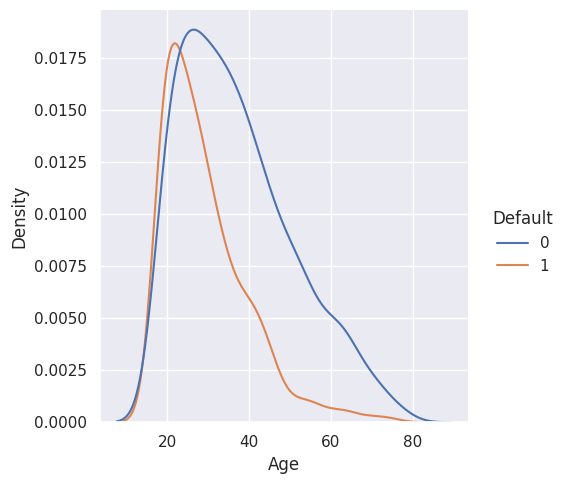

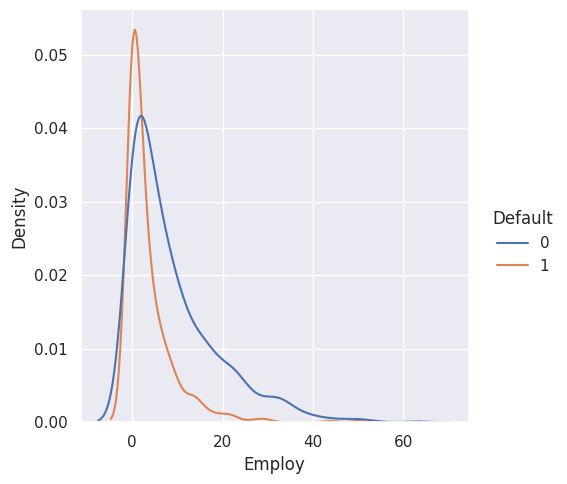

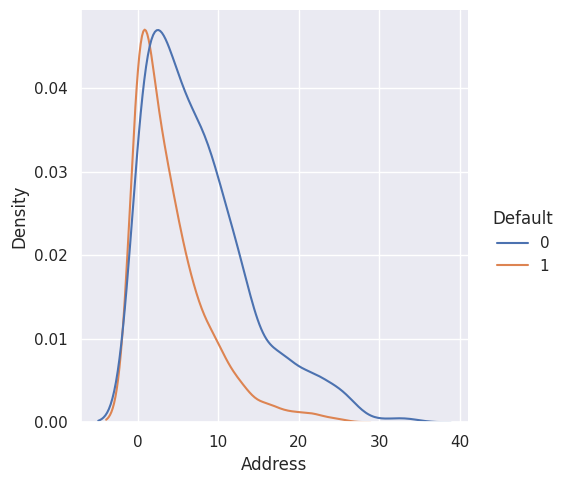

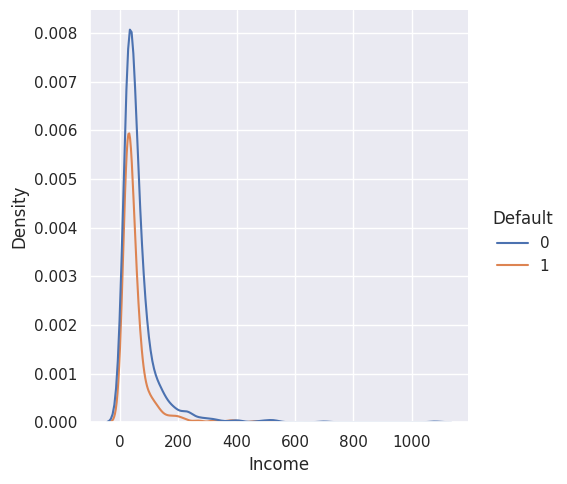

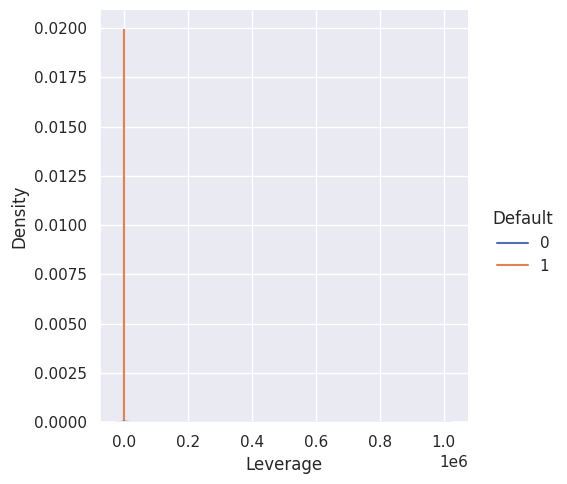

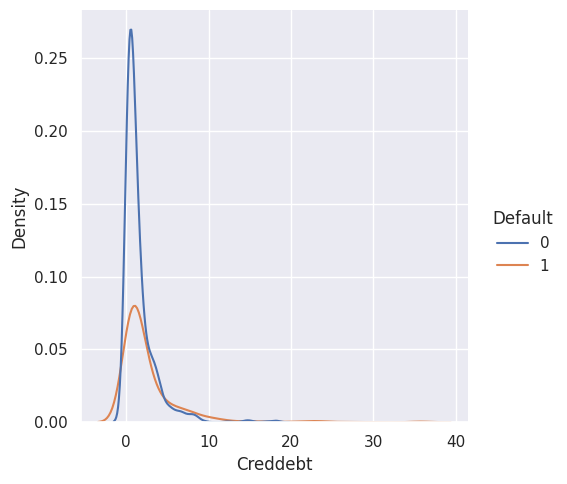

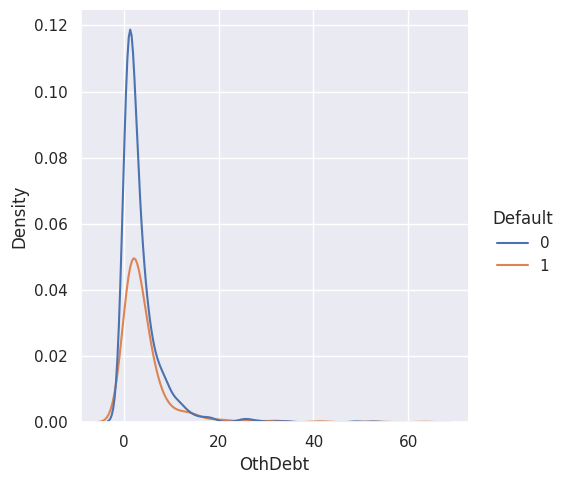

In [13]:
sns.set(color_codes=True)

for col_id in bankloan_data.select(pl.nth(np.r_[1,3:9].tolist())):
    sns.displot(data = bankloan_data, x = col_id, hue = "Default", kind = 'kde')

Seaborn can do many sophisticated (and aestetically pleasing)
graphs. Go to [the Gallery](https://seaborn.pydata.org/examples/index.html) for details and example code.

There are severe outliers in OthDebt, Leverage, Creddebt and Income, but we don't know which ones are valid and which invalid. We will treat these now.

## Data Cleaning

Now we can focus on cleaning the data. Let's start with the easy part: removing null values. **Remember to check when an outlier is a missing value** (invalid outliers).

### Null values

The core function here will be Polars' [```fill_null```](https://docs.pola.rs/api/python/dev/reference/expressions/api/polars.Expr.fill_null.html). This allows to replace all null values (represented by None or NaN in Python) by a certain value. This also allows to set what the replacement will be with the ```value``` argument. See the help for details.

Remember the strategies to deal :

1. Keep: If the null values are a category by themselves. In this case, replace by something meaningful.

2. Delete: If the null values are too many **either by row or by column** then it is better to just drop the case or the variable.

3. Replace: If there are only a few missings for the variable or the row (<1% total), replace by the  replace the null values by the **median** for continous variables, and the **mode** for categorical values.

Let's study our dataset's null values. The function [```null_count()```](https://docs.pola.rs/api/python/dev/reference/dataframe/api/polars.DataFrame.null_count.html#polars.DataFrame.null_count) gives us what we want.

In [29]:
# Count null values per column polars
bankloan_data.null_count()

customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,1,1,1,1,11,0,0


Given the small number of cases for all variables except OthDebt, we can simply replace those values by the median.

Let's study OthDebt cases more in detail. To get a horizontal slice of a dataset, we use the ```filter``` operation. As an argument, we ask polars to calculate the elements of ```OthDebt``` that are null.

In [30]:
bankloan_data.filter(pl.col("OthDebt").is_null())

customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
i64,i64,str,i64,i64,i64,f64,f64,f64,f64,i64
10423,19,"""Bas""",2,0,31,0.3,0.02,null,0.01,1
71896,20,"""SupInc""",0,0,21,1.3,0.18,null,0.07,1
72327,19,"""Med""",0,null,null,null,null,null,0.01,1
74471,39,"""Bas""",8,9,41,0.1,0.03,null,0.0,0
244023,31,"""SupCom""",1,7,69,0.4,0.19,null,0.01,0
…,…,…,…,…,…,…,…,…,…,…
315948,41,"""Med""",21,9,64,0.3,0.12,null,0.01,0
335635,18,"""Med""",0,0,24,0.9,0.13,null,0.05,1
372485,20,"""SupInc""",0,0,13,1.1,0.05,null,0.1,0


We can see all cases in which OthDebt is null. We can also see the egregious outlier that Leverage has, with a value of 9999999. These values give us some hints about what's happening with OthDebt. Let's study the minimum and maximum of the variables.

In [31]:
bankloan_data.select(pl.col('OthDebt')).describe()

statistic,OthDebt
str,f64
"""count""",1489.0
"""null_count""",11.0
"""mean""",3.872257
"""std""",5.34315
"""min""",0.1
"""25%""",1.12
"""50%""",2.24
"""75%""",4.61
"""max""",63.47


Aha! Note anything? There are no values equal to 0! We can make a good guess that the null values are equal to zero. In real life we would call the sysadmins to confirm this, but in this case we can make a guess.

Then, we now should fix these values as follow:

1. Replace the leverage equal to 999999 by a null value.
2. Replace all OthDebt nulls by 0.
3. Replace the remaining null values by the median.

In [32]:
# Replace invalid outlier.
bankloan_data = bankloan_data.with_columns(
    pl.when(pl.col("Leverage") == 9.99999e5)
    .then(None)
    .otherwise(pl.col("Leverage"))
    .alias("Leverage")
)

# Show new ranges. No more 999999!
bankloan_data.describe()

statistic,customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1500.0,1500.0,"""1500""",1500.0,1499.0,1499.0,1498.0,1499.0,1489.0,1500.0,1500.0
"""null_count""",0.0,0.0,"""0""",0.0,1.0,1.0,2.0,1.0,11.0,0.0,0.0
"""mean""",257714.548,34.174,null,6.952,6.30954,59.615077,9.942523,1.936197,3.872257,0.365447,0.365333
"""std""",139555.147719,13.142306,null,8.977644,6.047563,67.144768,6.666554,2.974485,5.34315,0.293937,0.481684
"""min""",10012.0,18.0,"""Bas""",0.0,0.0,12.0,0.1,0.0,0.1,0.0,0.0
"""25%""",98648.0,24.0,null,0.0,2.0,27.0,4.8,0.42,1.12,0.15,0.0
"""50%""",316013.0,31.0,null,4.0,5.0,40.0,8.5,0.99,2.24,0.29,0.0
"""75%""",370695.0,42.0,null,10.0,9.0,64.0,13.6,2.2,4.61,0.5,1.0
"""max""",453777.0,79.0,"""SupInc""",63.0,34.0,1079.0,40.7,35.97,63.47,2.15,1.0


In [33]:
# Fills out the null values in OthDebt with zeros.
bankloan_data = bankloan_data.with_columns(
    pl.col("OthDebt").fill_null(value=0)
)

In [27]:
# Remove null case if you want
# bankloan_data.with_row_index().filter(~pl.col("index").is_in(255))

In [45]:
# Get the column names for columns with null values
null_columns = bankloan_data.select(col for col in bankloan_data if col.is_null().any()).columns

# Get the median values of those columns
median_values = bankloan_data.select(pl.col(null_columns).median())

# Get array of expressions to replace
fill_expressions = []
for col_name in null_columns:
    # Get the median value for the current column
    median_value = median_values[col_name]

    # Create an expression to fill nulls in the current column with its median
    fill_expressions.append(pl.col(col_name).fill_null(median_value))

# Replace the values
bankloan_data = bankloan_data.with_columns(*fill_expressions)

# Check the result
bankloan_data.null_count()


customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0


In [46]:
bankloan_data.describe()

statistic,customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1500.0,1500.0,"""1500""",1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
"""null_count""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",257714.548,34.174,null,6.952,6.308667,59.602,9.9406,1.935567,3.84386,0.365447,0.365333
"""std""",139555.147719,13.142306,null,8.977644,6.04564,67.124278,6.662313,2.973593,5.333758,0.293937,0.481684
"""min""",10012.0,18.0,"""Bas""",0.0,0.0,12.0,0.1,0.0,0.0,0.0,0.0
"""25%""",98648.0,24.0,null,0.0,2.0,27.0,4.8,0.42,1.11,0.15,0.0
"""50%""",316013.0,31.0,null,4.0,5.0,40.0,8.5,0.99,2.22,0.29,0.0
"""75%""",370695.0,42.0,null,10.0,9.0,64.0,13.5,2.2,4.57,0.5,1.0
"""max""",453777.0,79.0,"""SupInc""",63.0,34.0,1079.0,40.7,35.97,63.47,2.15,1.0


There are no more null values! We are now ready to study the distributions.

### Outlier cleaning

Cleaning outlier, on the other hand, requires a much more manual intervention. We know there are three variables we need to intervene in: Income, Creddebt, and OthDebt. In general, we would like to modify all cases where there is either a discontinuous distribution or a case that is outside of 3 to 6 standard deviations.

It is very important to use your judgement in this! Don't just cut in 3 stds, as that is too restrictive in an exponential distribution. If you want to get an idea of the values, then seaborn can help. The function ```displot``` with either the option ```hist``` or ```kde``` allows to check the distribution of values.

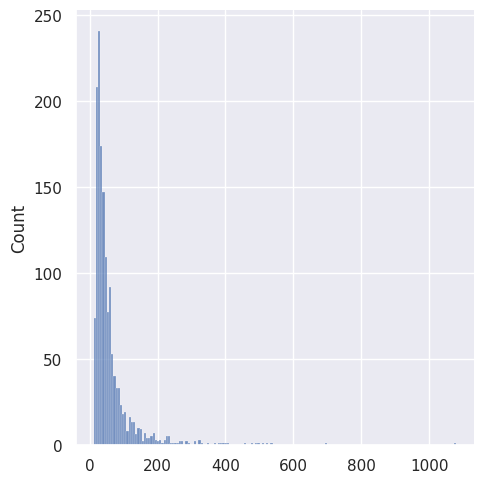

In [47]:
fig = sns.displot(bankloan_data['Income'], kind = 'hist')
plt.savefig('Income.pdf')
plt.show()

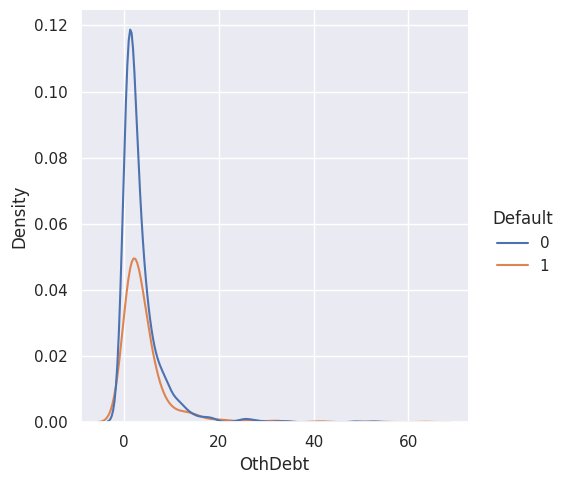

In [48]:
sns.displot(data = bankloan_data, x = 'OthDebt', kind = 'kde', hue = 'Default')
plt.show()

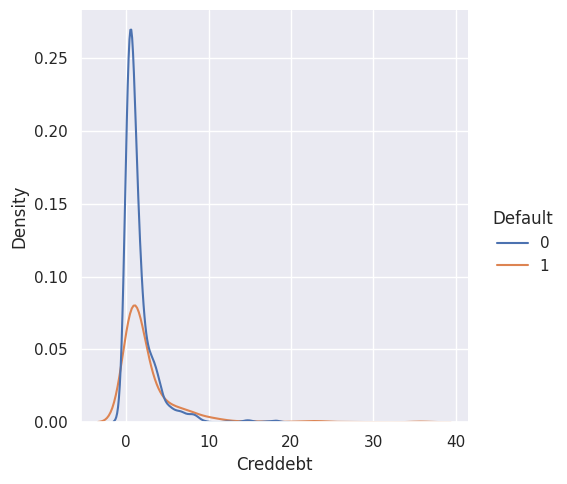

In [49]:
fig = sns.displot(data = bankloan_data, x = 'Creddebt', kind = 'kde', hue = 'Default')
plt.savefig('Creddebt.pdf')
plt.show()

Income needs to be trimmed from the right. OthDebt and Creddebt need to be truncated or left as is.

To actually cut the values, then we can simply write a proper expression in polars:

In [56]:
pl.Config.set_tbl_rows(50)
print(bankloan_data.select(pl.col("Income")).top_k(k=50, by="Income"))

shape: (50, 1)
┌────────┐
│ Income │
│ ---    │
│ f64    │
╞════════╡
│ 1079.0 │
│ 699.0  │
│ 533.0  │
│ 526.0  │
│ 512.0  │
│ 497.0  │
│ 493.0  │
│ 475.0  │
│ 460.0  │
│ 410.0  │
│ 403.0  │
│ 397.0  │
│ 387.0  │
│ 384.0  │
│ 368.0  │
│ 352.0  │
│ 327.0  │
│ 326.0  │
│ 322.0  │
│ 321.0  │
│ 314.0  │
│ 308.0  │
│ 289.0  │
│ 286.0  │
│ 285.0  │
│ 274.0  │
│ 274.0  │
│ 267.0  │
│ 263.0  │
│ 259.0  │
│ 251.0  │
│ 249.0  │
│ 238.0  │
│ 236.0  │
│ 234.0  │
│ 233.0  │
│ 232.0  │
│ 231.0  │
│ 229.0  │
│ 229.0  │
│ 227.0  │
│ 226.0  │
│ 225.0  │
│ 222.0  │
│ 220.0  │
│ 219.0  │
│ 215.0  │
│ 209.0  │
│ 208.0  │
│ 206.0  │
└────────┘


The decision of where to cut is a business one as much as a statistical one. We can, for example, leave the cut at 250, as tafter that the density of the values significantly goes down. You could, instead, truncate these values. But is the behaviour of a person making over a million a year the same as someone making $250k. Where that cutoff occurs is the decision we must make.

In [57]:
# Remove all rows where income is above 250
bankloan_data = bankloan_data.filter(pl.col("Income") < 250)

We can check now how the data looks like.

/tmp/ipython-input-4082456150.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=90);


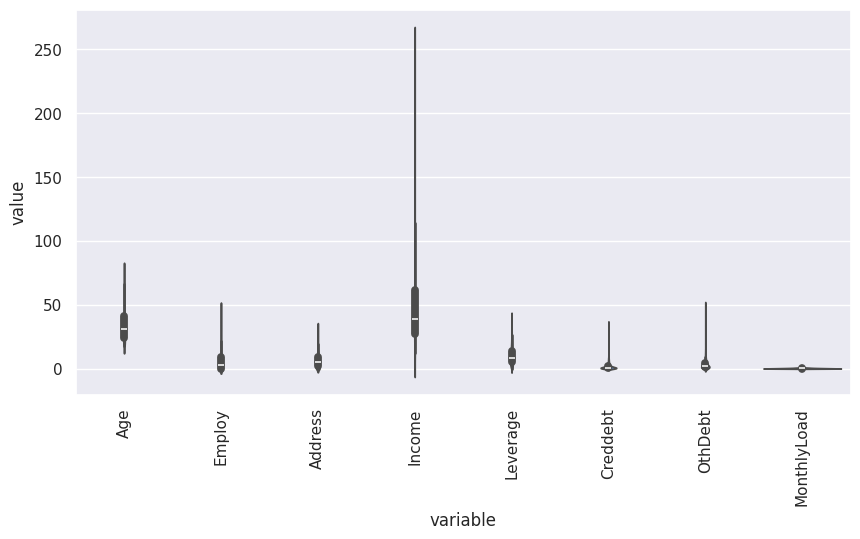

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
a = sns.violinplot(x='variable', y='value', data=pd.melt(bankloan_data.drop("customer", "Education", "Default").to_pandas()), ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

In [60]:
bankloan_data.describe()

statistic,customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1469.0,1469.0,"""1469""",1469.0,1469.0,1469.0,1469.0,1469.0,1469.0,1469.0,1469.0
"""null_count""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",257906.45337,33.710688,null,6.459496,6.112321,52.458816,9.981552,1.756712,3.518305,0.37098,0.366916
"""std""",139578.448732,12.759408,null,8.138399,5.873465,39.682706,6.674312,2.431015,4.32077,0.294323,0.482128
"""min""",10012.0,18.0,"""Bas""",0.0,0.0,12.0,0.1,0.0,0.0,0.0,0.0
"""25%""",98410.0,24.0,null,0.0,2.0,27.0,4.9,0.41,1.08,0.16,0.0
"""50%""",316077.0,31.0,null,3.0,5.0,39.0,8.6,0.95,2.18,0.3,0.0
"""75%""",370695.0,41.0,null,9.0,9.0,62.0,13.6,2.11,4.42,0.5,1.0
"""max""",453777.0,77.0,"""SupInc""",48.0,33.0,249.0,40.7,35.97,50.22,2.15,1.0


Much better, although income still has a large last quarter. This plot might be misleading though, as the magnitud of the data is relevant. We might want to recheck this after normalizing the data.

## Normalization

Most models require the inputs to be in the same scale, this is called **normalization**. It is very important for most models... except for credit scoring as we will use Weight of Evidence (see the lecture!). Still, this is fairly simple to do in Polars, being smart about what columns we select and **mapping** a function to those columns.

The most traditional mapping is the zscore. We can use scipy's version of it.



We now select all numeric columns, except the customer one. We can do this with ```select_dtypes```.

In [65]:
# Identify the numerical columns
numeric_cols = bankloan_data.select(cs.numeric() - cs.first() - cs.last()).columns
numeric_cols

['Age',
 'Employ',
 'Address',
 'Income',
 'Leverage',
 'Creddebt',
 'OthDebt',
 'MonthlyLoad']

In [73]:
# Apply the zscore function to columns in numeric_cols
bankloan_data_zscore = bankloan_data.select([
    ((pl.col(col) - pl.col(col).mean()) / pl.col(col).std()).alias(f"{col}_zscore")
    for col in numeric_cols
])

bankloan_data_zscore

Age_zscore,Employ_zscore,Address_zscore,Income_zscore,Leverage_zscore,Creddebt_zscore,OthDebt_zscore,MonthlyLoad_zscore
f64,f64,f64,f64,f64,f64,f64,f64
-0.447567,0.066414,-0.700152,-0.213161,1.156441,0.507314,0.296636,0.71017
2.373881,3.38402,1.853706,1.601231,0.706956,1.354697,1.963006,-0.343093
0.492916,1.66378,1.00242,0.215237,-0.776343,-0.29482,-0.376855,-0.81876
-0.29082,0.557911,-0.529895,-0.641559,3.673554,-0.002761,0.935411,4.243698
-0.682687,-0.547957,-0.700152,-0.56596,1.860633,-0.409998,0.565106,2.035243
0.101048,-0.547957,0.491648,-0.364361,0.137609,-0.122053,-0.194018,0.098598
-0.604314,-0.547957,-0.359638,-0.364361,0.287438,-0.331842,0.011964,0.200527
-0.682687,-0.302209,-0.700152,-0.56596,0.662008,-0.290707,-0.057468,0.846075
2.452254,2.769648,1.342934,3.440823,-0.746377,0.659514,0.595194,-0.988641


Now the data should look much better.

/tmp/ipython-input-1028815592.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=90);


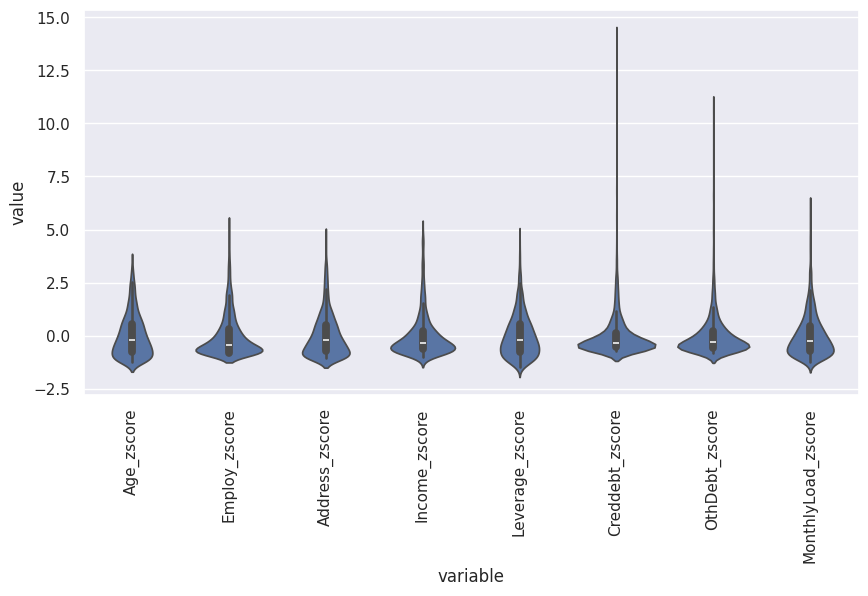

In [77]:
fig, ax = plt.subplots(figsize=(10,5))
a = sns.violinplot(x='variable', y='value', data=pd.melt(bankloan_data_zscore.to_pandas()), ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

The dataset looks really clean now. We are ready to use further models! To be 100% purist **you should first split between train and test set** before doing all of these analyses (so you should use the median of the train set). Please remember that when solving your coursework.

## Dummy coding

The final step will be transform the categorical variables to dummy variables. Again, this is **not necessary for credit scoring** as the WoE transform is much more robust. The best strategy here is to follow the 5% rule:

1. Aggregate by expert judgement (i.e. your opinion) until each group has more than 5% of data (1% if very large data) and there are all classes (by target variable) present.

2. Use target variable percentage (or classification trees) until you get a proper number of groups.

To check the number of cases for each default level, we can calculate a crosstab.

In [79]:
# Print a crosstab of Education and Default
pd.crosstab(bankloan_data['Education'], bankloan_data['Default'])


col_0,0,1
row_0,,
Bas,178,64
Med,323,196
Posg,54,26
SupCom,166,136
SupInc,209,117


We see all variables have at least 5% of cases. We could, if we wanted, group "Posg" with "SupCom" into a "HigherEd" class, considering they have a small percentage of cases.

In [85]:
# Group Posg and SupCom into one class.
bankloan_data = bankloan_data.with_columns(
    pl.when(pl.col("Education") == "Posg")
    .then(pl.lit("SupCom")) # We use pl.lit() to indicate "SupCom" is a value, not a variable
    .otherwise(pl.col("Education"))
    .alias("Education")
)

Now we can calculate the mean of each educational level.

In [86]:
# Mean Default for each level of Education variable
bankloan_data.select("Education", "Default").group_by('Education').mean()

Education,Default
str,f64
"""Med""",0.377649
"""SupCom""",0.424084
"""SupInc""",0.358896
"""Bas""",0.264463


Now we are ready to create dummies.

In [88]:
# Turn string variables into dummies
bankloan_data.to_dummies(cs.string())


customer,Age,Education_Bas,Education_Med,Education_SupCom,Education_SupInc,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
i64,i64,u8,u8,u8,u8,i64,f64,f64,f64,f64,f64,f64,i64
10012,28,0,1,0,0,7,2.0,44.0,17.7,2.99,4.8,0.58,0
10017,64,0,0,1,0,34,17.0,116.0,14.7,5.05,12.0,0.27,0
10030,40,1,0,0,0,20,12.0,61.0,4.8,1.04,1.89,0.13,0
10039,30,1,0,0,0,11,3.0,27.0,34.5,1.75,7.56,1.62,0
10069,25,1,0,0,0,2,2.0,30.0,22.4,0.76,5.96,0.97,1
10071,35,1,0,0,0,2,9.0,38.0,10.9,1.46,2.68,0.4,1
10096,26,0,0,0,1,2,4.0,38.0,11.9,0.95,3.57,0.43,1
10128,25,1,0,0,0,4,2.0,30.0,14.4,1.05,3.27,0.62,0
10129,65,0,0,1,0,29,14.0,189.0,5.0,3.36,6.09,0.08,0


Note this does **not** drop the first. If we want to, we need to explicitly say so.

In [90]:
# Turn string variables into dummies
bankloan_data = bankloan_data.to_dummies(cs.string(), drop_first=True)

We will now save the output to a compressed format which is very efficient to start whole data structures, [parquet](https://parquet.apache.org/docs/file-format/). The data size gets reduced to around 1/3 of the original csv, due to the efficiencies of the format.

In [91]:
# Save to parquet file
bankloan_data.write_parquet("bankloan_data.parquet")

Now we are ready to train models!